# **GIỚI THIỆU**


<h4>Thông tin nhóm 15 - Weather Prediction:</h4>
<ul>
  <li>Hồ Ngọc Ân - 20280001</li>
  <li>Trần Tuấn Thái - 20280082</li>
  <li>Huỳnh Quang Trung - 20280108</li>
  <li>Hỏa Ngọc Tú - 20280111</li>
</ul>

*   Trong bài báo này, nhóm sẽ sử dụng bộ dữ liệu "seattle-weather.csv" từ Kaggle để dùng trong việc phân tích và xây dựng các mô hình dự đoán tình trạng thời tiết dựa trên các điều kiện. Đây là một bộ dữ liệu bao gồm các điều kiện thời tiết dựa trên các mẫu và tình trạng thời tiết gắn với các điều kiện đó. [Link dataset from Kaggle](https://www.kaggle.com/datasets/ananthr1/weather-prediction)
* Đây là bộ dữ liệu thời tiết tại bang Seattle của Hoa Kỳ được ghi nhận theo từng ngày trong khoảng 4 năm.
*   Các mô hình được sử dụng trong bài báo cáo: Logistic Regression, Decision Tree, K-Nearest Neighbor Classifier (KNN).

# **GỌI CÁC THƯ VIỆN CẦN THIẾT**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import re
import itertools
import missingno as mso
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

# **1.TÌM HIỂU VÀ KHAI THÁC BỘ DỮ LIỆU**

## 1.1. PHÂN TÍCH CHUNG VỀ BỘ DỮ LIỆU

In [2]:
# Đọc bộ dữ liệu ở dạng RAW thông qua URL với thư viện pandas
data=pd.read_csv("https://raw.githubusercontent.com/trunghq0205/IntroductionToDataScience_MTH10171/main/seattle-weather.csv")
data.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [3]:
data.shape

(1461, 6)

Có **6 cột** với tổng cộng **1461 dòng** theo các quan sát trong tập dữ liệu

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


Có **6 biến** tương ứng với 6 cột trong bộ dữ liệu:
* 4 biến liên tục bao gồm: `precipitation`, `temp_max`, `temp_min`, `wind`
* 1 biến ghi nhận thông tin ngày: `date` có dạng YYYY-MM-DD
* 1 biến chỉ tình trạng thời tiết: `weather`

*   Biến `precipitation` chỉ thông tin lượng mưa của tất cả các dạng nước rơi xuống mặt đất như mưa, mưa đá, tuyết rơi hoặc mưa phùn.
*   Biến `temp_max` chỉ nhiệt độ cao nhất trong ngày.

*   Biến `temp_min` chỉ nhiệt độ thấp nhất trong ngày.
*   Biến `wind` lưu thông tin tốc độ gió trong ngày.

## 1.2. KHÁM PHÁ CÁC BIẾN DỮ LIỆU

Ở bước này, chúng ta sẽ tiến hành phân tích các biến trong bộ dữ liệu mà chúng ta đã thu được phía trên.

Trước tiên, chúng ta sẽ bắt đầu từ các biến phân loại. 

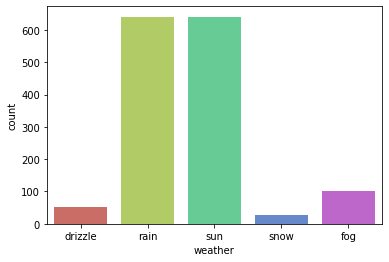

In [5]:
import warnings
warnings.filterwarnings('ignore')
sns.countplot("weather",data=data,palette="hls");

In [6]:
countrain=len(data[data.weather=="rain"])
countsun=len(data[data.weather=="sun"])
countdrizzle=len(data[data.weather=="drizzle"])
countsnow=len(data[data.weather=="snow"])
countfog=len(data[data.weather=="fog"])
print("Percent of Rain:{:2f}%".format((countrain/(len(data.weather))*100)))
print("Percent of Sun:{:2f}%".format((countsun/(len(data.weather))*100)))
print("Percent of Drizzle:{:2f}%".format((countdrizzle/(len(data.weather))*100)))
print("Percent of Snow:{:2f}%".format((countsnow/(len(data.weather))*100)))
print("Percent of Fog:{:2f}%".format((countfog/(len(data.weather))*100)))

Percent of Rain:43.874059%
Percent of Sun:43.805613%
Percent of Drizzle:3.627652%
Percent of Snow:1.779603%
Percent of Fog:6.913073%


* Từ đồ thị và các phân tích trên, ta có thể thấy tập dữ liệu chứa phần lớn là tình trạng thời tiết `rain` và `sun` với hơn 600 dòng dữ liệu và xấp xỉ nhau khi chiếm 43.3% bộ dữ liệu. Đối với các tình trạng thời tiết như `snow`, `fog` và `drizzle` thì có khoảng dưới 100 dòng dữ liệu với dưới 10% bộ dữ liệu.
* Nhận xét chung: Từ việc có ít dữ liệu đề cập đến `snow`, `fog` và `drizzle` thì có thể ảnh hưởng đến độ chính xác của mô hình khi dự đoán các tình trạng thời tiết snow, fog và drizzle khi quá quá ít dữ liệu để đào tạo.

## 1.3. CÁC BIẾN LIÊN TỤC

Tiếp theo, chúng ta sẽ tìm hiểu đến các biến số liên tục trong bộ dữ liệu, gồm: `precipitation`, `temp_max`, `temp_min`, `wind`

In [7]:
data[["precipitation","temp_max","temp_min","wind"]].describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


Ta xem phân phối của các biến giá trị bằng cách sử dụng đồ thị ***Histogram.***

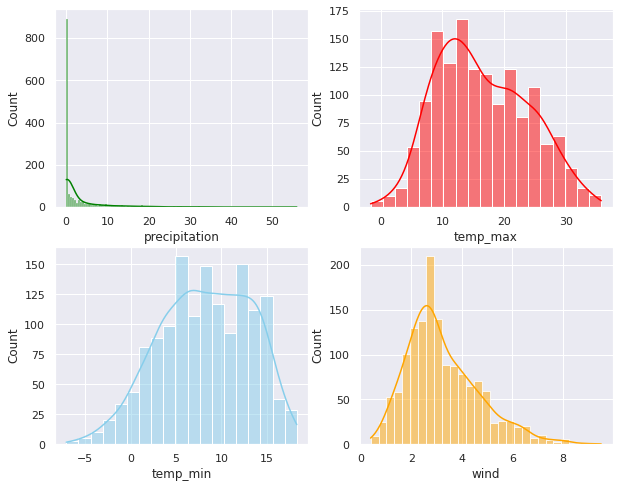

In [8]:
sns.set(style="darkgrid")
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.histplot(data=data,x="precipitation",kde=True,ax=axs[0,0],color='green');
sns.histplot(data=data,x="temp_max",kde=True,ax=axs[0,1],color='red');
sns.histplot(data=data,x="temp_min",kde=True,ax=axs[1,0],color='skyblue');
sns.histplot(data=data,x="wind",kde=True,ax=axs[1,1],color='orange');

* Từ các đồ thị phía trên, ta thấy rõ ràng phân phối của `precipitation`, `wind` và có độ **lệch tích cực (lệch phải)**. Đuôi bên phải dài hơn đuôi bên trái.
* Phân phối của `temp_min` có độ **lệch tiêu cực (lệch trái)** 
* Và cả hai đều có một số **giá trị ngoại lai (Outlier).**

## 1.4 SỬ DỤNG BOXPLOT TÌM CÁC GIÁ TRỊ NGOẠI LAI VÀ TÍNH LỆCH


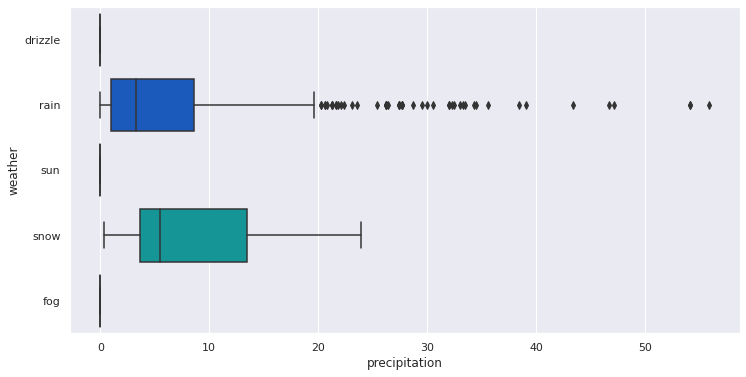

In [9]:
plt.figure(figsize=(12,6))
sns.boxplot("precipitation","weather",data=data,palette="winter");

Từ đồ thị box plot giữa ***Weather và Precipitation*** phía trên, giá trị của ***Rain*** có nhiều **dữ liệu ngoại lai dương** và cả **Rain và Snow** đều bị ***lệch phải/có độ lệch dương***

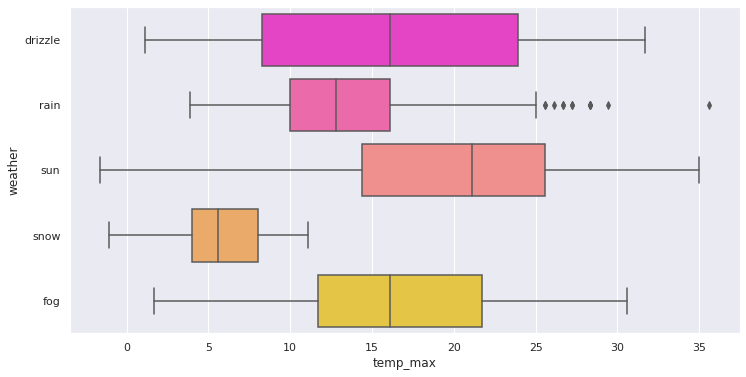

In [10]:
plt.figure(figsize=(12,6))
sns.boxplot("temp_max","weather",data=data,palette="spring");

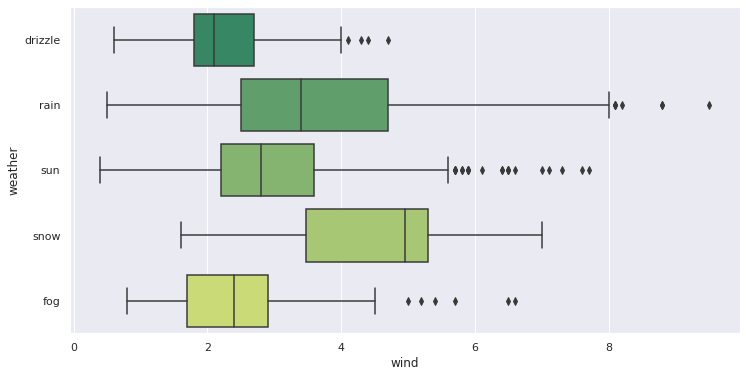

In [11]:
plt.figure(figsize=(12,6))
sns.boxplot("wind","weather",data=data,palette="summer");

Từ các đồ thị box plot phía trên, chúng ta thấy rằng mỗi ***thuộc tính của weather*** có một vài ***dữ liệu ngoại lai dương*** và bao gồm ***cả hai kiểu lệch***

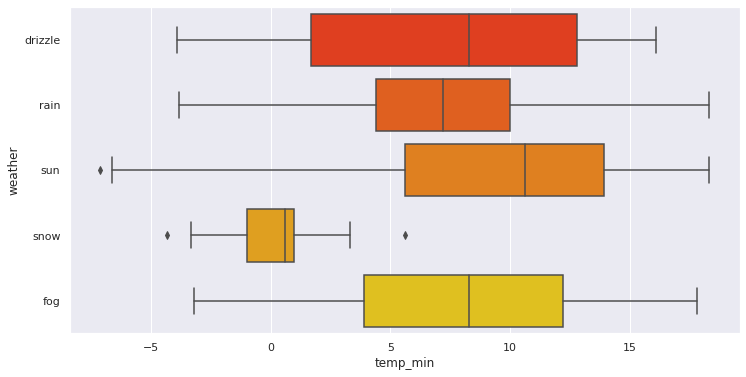

In [12]:
plt.figure(figsize=(12,6))
sns.boxplot("temp_min","weather",data=data,palette="autumn");

Tại đồ thị box plot giữa ***weather và temp_min***, một vài dữ liệu có giá trị âm và một vài dữ liệu có cả hai loại giá trị ngoại lai âm và dương, trong đó snow bị lệch trái.

## 1.5 KHÁM PHÁ CÁC BIẾN SỐ


Pearson correlation: -0.22855481643297046
T Test and P value: Ttest_indResult(statistic=-51.60685279531918, pvalue=0.0)


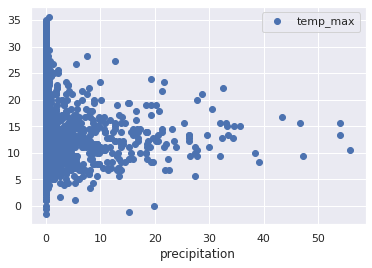

In [13]:
data.plot("precipitation","temp_max",style='o') 
print("Pearson correlation:",data["precipitation"].corr(data["temp_max"]))
print("T Test and P value:",stats.ttest_ind(data["precipitation"],data["temp_max"]))

Pearson correlation: -0.16485663487495486
T Test and P value: Ttest_indResult(statistic=-67.3601643301846, pvalue=0.0)


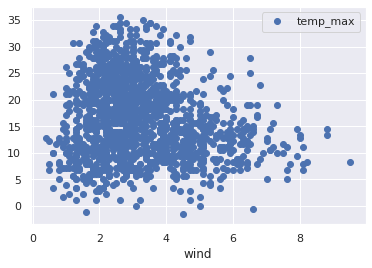

In [14]:
data.plot("wind","temp_max",style='o') 
print("Pearson correlation:",data["wind"].corr(data["temp_max"]))
print("T Test and P value:",stats.ttest_ind(data["wind"],data["temp_max"]))

Theo kết quả của ***T test và P value bằng 0*** ở trên chứng tỏ rằng ***Giả thuyết H0*** trong các cột tương ứng bị **bác bỏ** và các cột đều có ***Ý nghĩa thống kê***.

Đồng thời, ta cũng thấy hệ số tương quan giữa các cặp biến trên đều nằm trong khoảng -1 < r < 0, điều này có nghĩa là chúng có mối tương quan yếu với nhau hay có hệ số tương quan âm và chúng không có mối quan hệ tuyến tính với nhau. Nghĩa là giá trị biến x tăng thì giá trị biến y giảm và ngược lại, giá trị biến y tăng thì giá trị biến x giảm.

Pearson correlation: 0.8756866637108172
T Test and P value: Ttest_indResult(statistic=35.22645781239284, pvalue=7.526905087245157e-227)


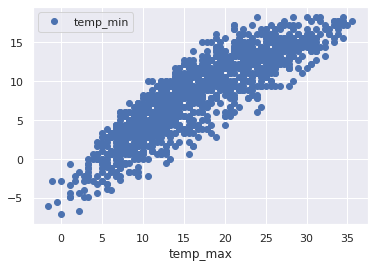

In [15]:
data.plot("temp_max","temp_min",style='o')
print("Pearson correlation:",data["temp_max"].corr(data["temp_min"]))
print("T Test and P value:",stats.ttest_ind(data["temp_max"],data["temp_min"]))

Dựa vào đồ thị trên, ta có thể nhận xét rằng là biến `temp_min` và biến `temp_max` có mối quan hệ tương quan dương với nhau và mối quan hệ tuyến tính này khá mạnh với hệ số tương quan 0.87 gần bằng 1. Nghĩa là giá trị biến x tăng thì giá trị biến y tăng và ngược lại, giá trị biến y tăng thì giá trị biến x cũng tăng. 

## 1.6 CÁC GIÁ TRỊ NULL

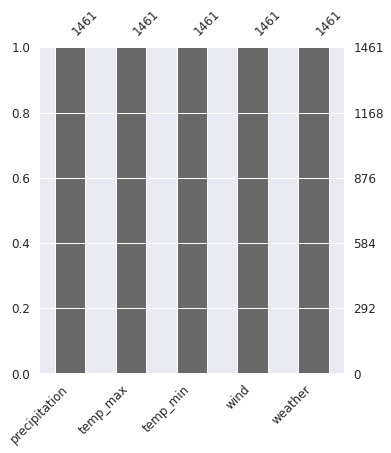

In [16]:
plt.figure(figsize=(12,6))
axz=plt.subplot(1,2,2)
mso.bar(data.drop(["date"],axis=1),ax=axz,fontsize=12);

**Kiểm tra sự tồn tại của các giá trị  NULL trong bộ dữ liệu**

Bằng cách quan sát biểu đồ ở phía trên, ta có thể kết luận rằng không tồn tại các giá trị NULL ở các biến bởi vì các cột đều có 1461 quan sát bằng đúng với số dòng của dữ liệu.

# **2.TIỀN XỬ LÝ VÀ LÀM SẠCH DỮ LIỆU:**

## 2.1. LOẠI BỎ CÁC BIẾN KHÔNG CẦN THIẾT

Giả định đầu tiên ở đây chính là trong bộ dữ liệu này, biến `date` là biến dữ liệu không cần thiết, không cần sử dụng đến, không gây ảnh hưởng đến kết quả trong quá trình xây dựng các mô hình dự báo của chúng ta. Vì vậy trong trường hợp đầu tiên, ta sẽ tiến hành loại bỏ biến này ra khỏi bộ dữ liệu.

In [17]:
df=data.drop(["date"],axis=1)
df.head()

,precipitation,temp_max,temp_min,wind,weather
0,0.0,12.8,5.0,4.7,drizzle
1,10.9,10.6,2.8,4.5,rain
2,0.8,11.7,7.2,2.3,rain
3,20.3,12.2,5.6,4.7,rain
4,1.3,8.9,2.8,6.1,rain


## 2.2. LOẠI BỎ CÁC ĐIỂM OUTLIER VÀ CÁC GIÁ TRỊ VÔ HẠN

Vì trong bộ dữ liệu trên có chứa các ***Giá trị ngoại lai***, chúng ta sẽ loại bỏ chúng để làm cho bộ dữ liệu đồng đều hơn.

Chúng ta loại bỏ đi những điểm Outlier bằng cách tính khoảng tứ phân vị, sau đó loại đi những giá trị nằm ngoài khoảng (Q1-1.5*IQR, Q3+1.5*IQR). Những điểm nằm ngoài khoảng này đươc gọi là những điểm ngoại lai (outlier).

In [18]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3-Q1
df = df[~((df<(Q1-1.5*IQR))|(df>(Q3+1.5*IQR))).any(axis=1)]

## 2.3. XỬ LÝ CÁC PHÂN PHỐI LỆCH

Ta xử lý hai biến có phân phối lệch là “precipition” và “wind” bằng cách 
lấy căn bậc 2 của chúng.

In [19]:
df.precipitation=np.sqrt(df.precipitation)
df.wind=np.sqrt(df.wind)

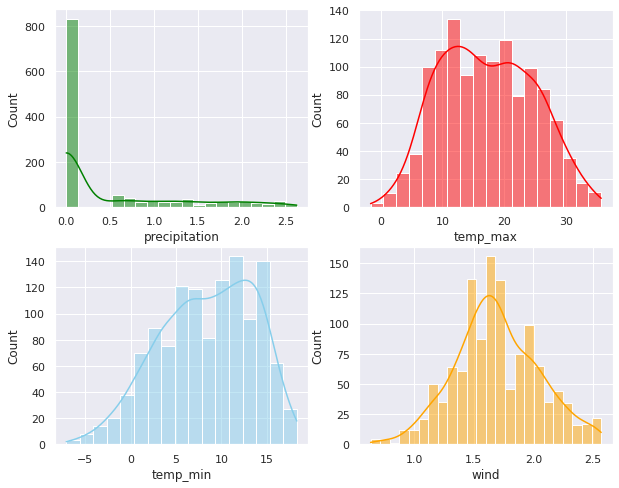

In [20]:
sns.set(style="darkgrid")
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.histplot(data=df,x="precipitation",kde=True,ax=axs[0,0],color='green');
sns.histplot(data=df,x="temp_max",kde=True,ax=axs[0,1],color='red');
sns.histplot(data=df,x="temp_min",kde=True,ax=axs[1,0],color='skyblue');
sns.histplot(data=df,x="wind",kde=True,ax=axs[1,1],color='orange');

In [21]:
df.head()

,precipitation,temp_max,temp_min,wind,weather
0,0.000000,12.8,5.0,2.167948,drizzle
2,0.894427,11.7,7.2,1.516575,rain
4,1.140175,8.9,2.8,2.469818,rain
5,1.581139,4.4,2.2,1.483240,rain
6,0.000000,7.2,2.8,1.516575,rain


Mã hóa các nhãn dữ liệu ở biến `weather` thành các giá trị từ 0 - 4 sử dụng hàm LabelEncoder():

In [22]:
lc=LabelEncoder()
df["weather"]=lc.fit_transform(df["weather"])

In [23]:
df.head()

,precipitation,temp_max,temp_min,wind,weather
0,0.000000,12.8,5.0,2.167948,0
2,0.894427,11.7,7.2,1.516575,2
4,1.140175,8.9,2.8,2.469818,2
5,1.581139,4.4,2.2,1.483240,2
6,0.000000,7.2,2.8,1.516575,2


Ta có thể thấy các nhãn dữ liệu trong biến `weather` đã được mã hóa như sau: giá trị 0 tương ứng với Dizzle, giá trị 1 tương ứng với Fog, giá trị 2 tương ứng với rain, giá trị 3 tương ứng với Snow, giá trị 4 tương ứng với Sun.

**Phân tách tập dữ liệu thành biến phụ thuộc và biến độc lập:**

In [24]:
x = ((df.loc[:,df.columns!="weather"]).astype(int)).values[:,0:]
y = df["weather"].values

In [25]:
df.weather.unique()

array([0, 2, 4, 3, 1])

In [26]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=2)

Ta chia bộ dữ liệu thành hai tập dữ liệu riêng biệt bao gồm tập dữ liệu đào tạo và tập dữ liệu kiểm thử với tỷ lệ tương ứng là 9:1.

# **3.ĐÀO TẠO MÔ HÌNH:**

## 3.1. K-NEAREST NEIGHBOR CLASSIFIER.

In [70]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
knn.fit(x_train,y_train)
knn_score = knn.score(x_test,y_test)
print("KNN Accuracy:", knn_score)

KNN Accuracy: 0.75


In [28]:
y_pred_knn = knn.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix")
print(conf_matrix)

Confusion Matrix
[[ 0  0  0  0  1]
 [ 0  2  4  0  5]
 [ 1  0 26  0  6]
 [ 0  0  1  1  1]
 [ 1  5  6  0 64]]


In [29]:
print('KNN\n',classification_report(y_test,y_pred_knn, zero_division=0))

KNN
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.29      0.18      0.22        11
           2       0.70      0.79      0.74        33
           3       1.00      0.33      0.50         3
           4       0.83      0.84      0.84        76

    accuracy                           0.75       124
   macro avg       0.56      0.43      0.46       124
weighted avg       0.75      0.75      0.74       124



## 3.2. DECISION TREE.

Ta tiến hành xây dựng mô hình với các tham số max_depth khác nhau từ 1 đến 7 để tìm lấy mô hình có tham số với độ chính xác tốt nhất.

In [30]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
max_depth_range = list(range(1, 8))
for depth in max_depth_range:
  dec = DecisionTreeClassifier(max_depth = depth, max_leaf_nodes=15,random_state=0)
  dec.fit(x_train,y_train)
  dec_score = dec.score(x_test,y_test)
  print("Decison Tree Accuracy : ", dec_score)

Decison Tree Accuracy :  0.8064516129032258
Decison Tree Accuracy :  0.8145161290322581
Decison Tree Accuracy :  0.8225806451612904
Decison Tree Accuracy :  0.8145161290322581
Decison Tree Accuracy :  0.8306451612903226
Decison Tree Accuracy :  0.8306451612903226
Decison Tree Accuracy :  0.8306451612903226


Ta nhận thấy rằng với max_depth nằm trong khoảng từ 5 đến 7 ta sẽ có được mô hình Decision Tree tốt nhất với 0.83 độ tin cậy.

In [31]:
y_pred_dec = dec.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred_dec)
print("Confusion Matrix")
print(conf_matrix)

Confusion Matrix
[[ 0  0  0  0  1]
 [ 0  0  0  0 11]
 [ 0  0 25  0  8]
 [ 0  0  0  3  0]
 [ 0  0  1  0 75]]


In [32]:
print('Decision Tree\n',classification_report(y_test,y_pred_dec, zero_division=0))

Decision Tree
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        11
           2       0.96      0.76      0.85        33
           3       1.00      1.00      1.00         3
           4       0.79      0.99      0.88        76

    accuracy                           0.83       124
   macro avg       0.55      0.55      0.54       124
weighted avg       0.76      0.83      0.79       124



## 3.3. LOGISTIC REGRESSION

In [33]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
lg.fit(x_train,y_train)
lg_score = lg.score(x_test,y_test)
print("Logistic Accuracy : ", lg_score)

Logistic Accuracy :  0.8064516129032258


In [34]:
y_pred_lg = lg.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred_lg)
print("Confusion Matrix")
print(conf_matrix)

Confusion Matrix
[[ 0  0  0  0  1]
 [ 0  0  3  0  8]
 [ 0  0 26  0  7]
 [ 0  0  3  0  0]
 [ 0  0  2  0 74]]


In [35]:
print('Logistic Regression\n',classification_report(y_test,y_pred_lg, zero_division=0))

Logistic Regression
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        11
           2       0.76      0.79      0.78        33
           3       0.00      0.00      0.00         3
           4       0.82      0.97      0.89        76

    accuracy                           0.81       124
   macro avg       0.32      0.35      0.33       124
weighted avg       0.71      0.81      0.75       124



## 3.4. BIỂU ĐỒ SO SÁNH ĐỘ TIN CẬY CÁC MÔ HÌNH.

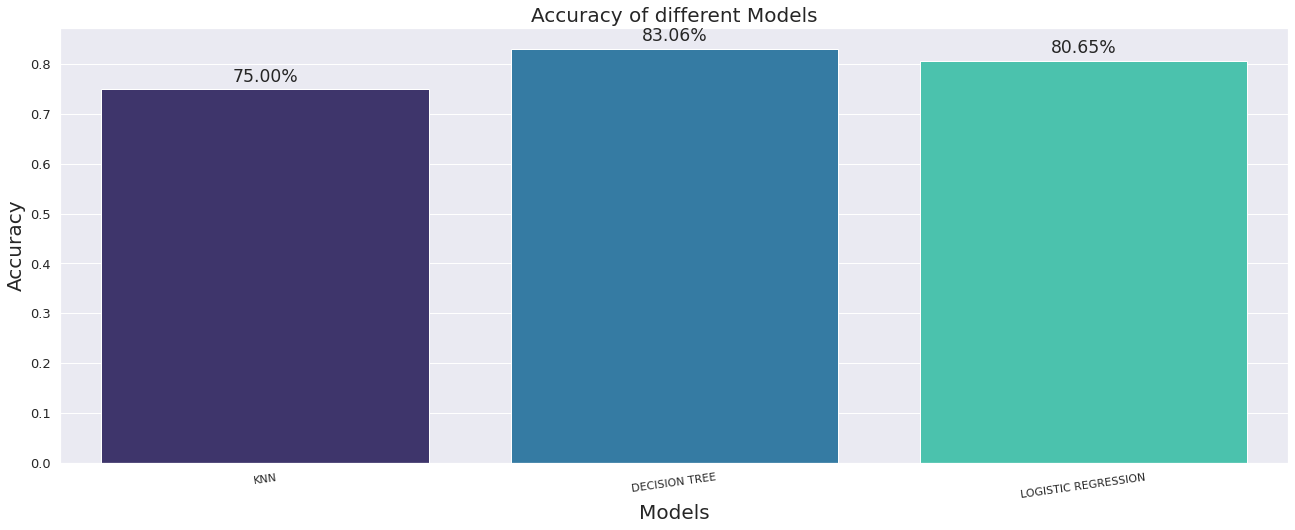

In [36]:
mylist=[]
mylist2=[]
mylist.append(knn_score)
mylist2.append("KNN")
mylist.append(dec_score)
mylist2.append("DECISION TREE")
mylist.append(lg_score)
mylist2.append("LOGISTIC REGRESSION")
plt.rcParams['figure.figsize']=8,6
sns.set_style("darkgrid")
plt.figure(figsize=(22,8))
ax = sns.barplot(x=mylist2, y=mylist, palette = "mako", saturation =1.5)
plt.xlabel("Models", fontsize = 20 )
plt.ylabel("Accuracy", fontsize = 20)
plt.title("Accuracy of different Models", fontsize = 20)
plt.xticks(fontsize = 11, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

## 3.5. XÂY DỰNG CÁC MODEL TRONG TRƯỜNG HỢP GIỮ NGUYÊN BIẾN `date`.

Câu hỏi tiếp theo đặt ra ở đây đó chính là liệu biến `date` có ảnh hưởng đến độ chính xác của mô hình hay không. Ví dụ như thời tiết của chúng ta bị ảnh hưởng theo từng mùa trong năm chẳng hạn, chính vì vậy ta tiếp tục xây dựng mô hình với bộ dữ liệu không loại bỏ đi biến `date` để kiểm tra giả thuyết này.

In [37]:
df_date = pd.read_csv("https://raw.githubusercontent.com/trunghq0205/IntroductionToDataScience_MTH10171/main/seattle-weather.csv")
df_date.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [38]:
df_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


Đầu tiên, chúng ta chuyển kiểu dữ liệu ở biến date từ dạng chuỗi chuyển sang kiểu dữ liệu Datetime. Sau đó, loại bỏ đi thuộc tính ngày và năm trong `date`, trích xuất và giữ lại thuộc tính tháng vì thông thường thời tiết thường phụ thuộc theo các mùa trong năm và các mùa trong năm cũng thay đổi theo tháng.

In [39]:
df_date.date = pd.to_datetime(df_date.date).dt.month
df_date.date

0        1
1        1
2        1
3        1
4        1
        ..
1456    12
1457    12
1458    12
1459    12
1460    12
Name: date, Length: 1461, dtype: int64

Ta thực hiện đổi tên biến `date` thành `month` cho phù hợp với trường dữ liệu mà nó lưu giữ.

In [40]:
df_date = df_date.rename(columns = {'date':'month'})
df_date.head()

,month,precipitation,temp_max,temp_min,wind,weather
0,1,0.0,12.8,5.0,4.7,drizzle
1,1,10.9,10.6,2.8,4.5,rain
2,1,0.8,11.7,7.2,2.3,rain
3,1,20.3,12.2,5.6,4.7,rain
4,1,1.3,8.9,2.8,6.1,rain


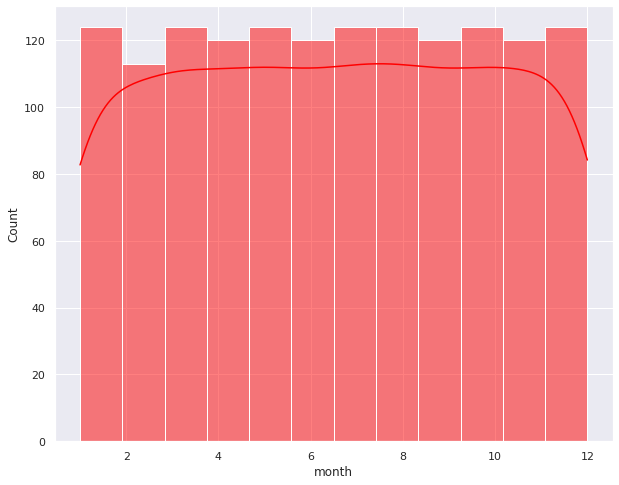

In [41]:
sns.set(style="darkgrid")
fig,axs = plt.subplots(figsize=(10,8))
plot = sns.histplot(data=df_date,x = "month",kde=True,color='red');

### 3.5.1. XỬ LÝ VÀ LÀM SẠCH DỮ LIỆU.

Tương tự như ở phần trước, chúng ta cũng sẽ bắt đầu xử lý và làm sạch dữ liệu trước khi xây dựng các mô hình dự báo. Bước này đã được thực hiện khá chi tiết ở phần trình bày phía trên nên chúng ta sẽ không nhắc lại ở bước này. Bao gồm: loại bỏ các điểm ngoại lai, xử lý các phân phối lệch, mã hóa dữ liệu biến `weather` và phân tách tập dữ liệu thành các tập train và test.

In [42]:
# Loại bỏ các điểm Outlier.
Q1_date = df_date.quantile(0.25)
Q3_date = df_date.quantile(0.75)
IQR_date = Q3_date - Q1_date
df_date = df_date[~((df_date<(Q1_date-1.5*IQR_date))|(df_date>(Q3_date+1.5*IQR_date))).any(axis=1)]

In [43]:
# Xử lý các phân phối lệch.
df_date.precipitation=np.sqrt(df_date.precipitation)
df_date.wind=np.sqrt(df_date.wind)

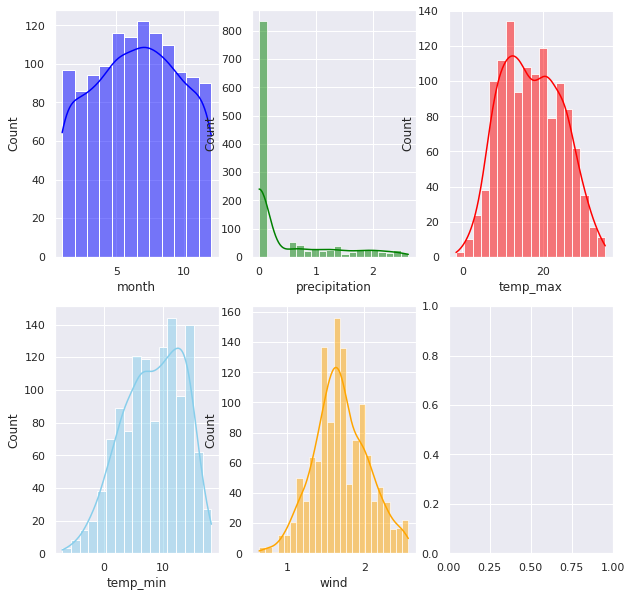

In [44]:
sns.set(style="darkgrid")
fig,axs=plt.subplots(2,3,figsize=(10,10))
sns.histplot(data=df_date,x="month",kde=True,ax=axs[0,0],color='blue');
sns.histplot(data=df_date,x="precipitation",kde=True,ax=axs[0,1],color='green');
sns.histplot(data=df_date,x="temp_max",kde=True,ax=axs[0,2],color='red');
sns.histplot(data=df_date,x="temp_min",kde=True,ax=axs[1,0],color='skyblue');
sns.histplot(data=df_date,x="wind",kde=True,ax=axs[1,1],color='orange');


Tiếp đến, ta mã hóa các tình trạng thời tiết thành các giá trị từ 0-4, sau đó phân tách dữ liệu thành các tập train và test.

In [45]:
lc_date=LabelEncoder()
df_date["weather"]=lc_date.fit_transform(df_date["weather"])
df_date.head()

,month,precipitation,temp_max,temp_min,wind,weather
0,1,0.000000,12.8,5.0,2.167948,0
2,1,0.894427,11.7,7.2,1.516575,2
4,1,1.140175,8.9,2.8,2.469818,2
5,1,1.581139,4.4,2.2,1.483240,2
6,1,0.000000,7.2,2.8,1.516575,2


In [46]:
x_date = ((df_date.loc[:,df_date.columns!="weather"]).astype(int)).values[:,0:]
y_date = df_date["weather"].values

In [47]:
x_train_date,x_test_date,y_train_date,y_test_date=train_test_split(x_date,y_date,test_size=0.1,random_state=2)

### 3.5.2. K-NEIGHBOR NEAREST CLASSIFIER.

In [48]:
from sklearn.neighbors import KNeighborsClassifier
knn_date = KNeighborsClassifier()
knn_date.fit(x_train_date,y_train_date)
knn_date_score = knn_date.score(x_test_date,y_test_date)
print("KNN Accuracy (with month column):", knn_date_score)

KNN Accuracy (with month column): 0.7338709677419355


In [49]:
y_pred_knn_date = knn_date.predict(x_test_date)
conf_matrix_knn_date = confusion_matrix(y_test_date, y_pred_knn_date)
print("Confusion Matrix (with month column)")
print(conf_matrix_knn_date)

Confusion Matrix (with month column)
[[ 0  0  0  0  1]
 [ 0  3  3  0  5]
 [ 0  2 24  0  7]
 [ 1  0  0  1  1]
 [ 1  3  9  0 63]]


In [50]:
print('KNN (with month column)\n',classification_report(y_test_date,y_pred_knn_date, zero_division=0))

KNN (with month column)
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.38      0.27      0.32        11
           2       0.67      0.73      0.70        33
           3       1.00      0.33      0.50         3
           4       0.82      0.83      0.82        76

    accuracy                           0.73       124
   macro avg       0.57      0.43      0.47       124
weighted avg       0.74      0.73      0.73       124



Ta có thể nhận xét rằng việc có thêm biến `month` trong việc đào tạo mô hình ở trường hợp này đã làm giảm độ tin cậy của mô hình sử dụng KNN từ 0.75 xuống còn xấp xỉ 0.734.

### 3.5.3. DECISION TREE.

In [51]:
from sklearn.tree import DecisionTreeClassifier
max_depth_range_date = list(range(1, 8))
for depth in max_depth_range_date:
  dec_date = DecisionTreeClassifier(max_depth = depth, max_leaf_nodes = 15,random_state=0)
  dec_date.fit(x_train_date,y_train_date)
  dec_date_score = dec_date.score(x_test_date,y_test_date)
  print("Decison Tree Accuracy (with month column): ", dec_date_score)

Decison Tree Accuracy (with month column):  0.8064516129032258
Decison Tree Accuracy (with month column):  0.8145161290322581
Decison Tree Accuracy (with month column):  0.8225806451612904
Decison Tree Accuracy (with month column):  0.8306451612903226
Decison Tree Accuracy (with month column):  0.7983870967741935
Decison Tree Accuracy (with month column):  0.8225806451612904
Decison Tree Accuracy (with month column):  0.7983870967741935


In [52]:
y_pred_dec_date = dec_date.predict(x_test_date)
conf_matrix_dec_date = confusion_matrix(y_test_date, y_pred_dec_date)
print("Confusion Matrix (with month column)")
print(conf_matrix_dec_date)

Confusion Matrix (with month column)
[[ 0  0  0  0  1]
 [ 0  0  2  0  9]
 [ 0  0 26  0  7]
 [ 0  0  1  2  0]
 [ 0  0  5  0 71]]


In [53]:
print('Decision Tree (with month column)\n',classification_report(y_test_date,y_pred_dec_date, zero_division=0))

Decision Tree (with month column)
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        11
           2       0.76      0.79      0.78        33
           3       1.00      0.67      0.80         3
           4       0.81      0.93      0.87        76

    accuracy                           0.80       124
   macro avg       0.51      0.48      0.49       124
weighted avg       0.72      0.80      0.76       124



Ta có thể nhận xét rằng trong trường hợp đào tạo mô hình có thêm biến `month` thì độ tin cậy của mô hình sử dụng cây quyết định đã có sự thay đổi. Khi `max_depth` = 7 thì độ tin cậy của mô hình đã giảm đi so với trường hợp không có biến `month` (từ 0.83 xuống còn xấp xỉ 0.799). Nhưng trong trường hợp này, khi `max_depth = 4` thì độ tin cậy đạt được là 0.83, bằng đúng với trường hợp ở phía trên (trường hợp không có biến `month`).

### 3.5.4. LOGISTIC REGRESSION.

In [54]:
from sklearn.linear_model import LogisticRegression
lg_date = LogisticRegression()
lg_date.fit(x_train_date,y_train_date)
lg_date_score = lg_date.score(x_test_date,y_test_date)
print("Logistic Accuracy (with month column): ", lg_date_score)

Logistic Accuracy (with month column):  0.8064516129032258


In [55]:
y_pred_lg_date = lg_date.predict(x_test_date)
conf_matrix_date = confusion_matrix(y_test_date, y_pred_lg_date)
print("Confusion Matrix (with month column)")
print(conf_matrix_date)

Confusion Matrix (with month column)
[[ 0  0  0  0  1]
 [ 0  0  2  0  9]
 [ 0  0 26  0  7]
 [ 0  0  3  0  0]
 [ 0  0  2  0 74]]


In [56]:
print('Logistic Regression (with month column)\n',classification_report(y_test_date,y_pred_lg_date, zero_division=0))

Logistic Regression (with month column)
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        11
           2       0.79      0.79      0.79        33
           3       0.00      0.00      0.00         3
           4       0.81      0.97      0.89        76

    accuracy                           0.81       124
   macro avg       0.32      0.35      0.33       124
weighted avg       0.71      0.81      0.75       124



Dựa vào trên ta thấy việc có thêm biến `month` vẫn không làm thay đổi độ tin cậy của mô hình sử dụng Logistic Regression.

**Như vây, việc sử dụng thêm biến `month` được trích xuất từ biến `date` để đào tạo mô hình cho kết quả không mấy khả quan khi có tới 1 mô hình bị giảm độ tin cậy (KNN), 2 mô hình không thay đổi độ tin cậy là Decision Tree và Logistic Regression (trong đó, đối với Decision Tree ta phải thay đổi max_depth từ 7 thành 4 mới có thể giữ nguyên được độ tin cậy của mô hình).**

### 3.5.5. TRƯỜNG HỢP GIỮ NGUYÊN BIẾN `date` THEO ĐỊNH DẠNG YYYY-MM-DD.
Một thử nghiệm cuối cùng đó chính là trường hợp ta giữ nguyên biến `date` theo định dạng YYYY-MM-DD để kiểm tra ảnh hưởng của nó đến kết quả cuối cùng.

In [57]:
df3 = pd.read_csv("https://raw.githubusercontent.com/trunghq0205/IntroductionToDataScience_MTH10171/main/seattle-weather.csv")
df3.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [58]:
# Loại bỏ các điểm Outlier.
Q1 = df3.quantile(0.25)
Q3 = df3.quantile(0.75)
IQR = Q3 - Q1
df3 = df3[~((df3<(Q1-1.5*IQR))|(df3>(Q3+1.5*IQR))).any(axis=1)]

In [59]:
# Xử lý các phân phối lệch.
df3.precipitation=np.sqrt(df3.precipitation)
df3.wind=np.sqrt(df3.wind)

In [60]:
lc = LabelEncoder()
df3["weather"]=lc.fit_transform(df3["weather"])
df3.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.000000,12.8,5.0,2.167948,0
2,2012-01-03,0.894427,11.7,7.2,1.516575,2
4,2012-01-05,1.140175,8.9,2.8,2.469818,2
5,2012-01-06,1.581139,4.4,2.2,1.483240,2
6,2012-01-07,0.000000,7.2,2.8,1.516575,2


In [61]:
df3.date = pd.to_datetime(df3.date)
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1233 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1233 non-null   datetime64[ns]
 1   precipitation  1233 non-null   float64       
 2   temp_max       1233 non-null   float64       
 3   temp_min       1233 non-null   float64       
 4   wind           1233 non-null   float64       
 5   weather        1233 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 67.4 KB


In [62]:
x_df3 = ((df3.loc[:,df3.columns!="weather"]).astype(np.int64)).values[:,0:]
y_df3 = df3["weather"].values

In [63]:
x_train_df3,x_test_df3,y_train_df3,y_test_df3 = train_test_split(x_df3,y_df3,test_size=0.1,random_state=2)

**K-NEIGHBOR NEAREST CLASSIFIER.**

In [64]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
knn_df3 = KNeighborsClassifier()
knn_df3.fit(x_train_df3,y_train_df3)
knn_score_df3 = knn_df3.score(x_test_df3,y_test_df3)
print("KNN Accuracy:", knn_score_df3)

KNN Accuracy: 0.6290322580645161


* Mô hình K-Neighbor Nearest Classifier đã giảm độ chính xác xuống chỉ còn 0.629. So với 2 trường hợp ở phía trên thì trường hợp này cho kết quả xấu nhất.

**DECISION TREE.**

In [65]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
max_depth_range = list(range(1, 8))
for depth in max_depth_range:
  dec_df3 = DecisionTreeClassifier(max_depth = depth, max_leaf_nodes=15,random_state=0)
  dec_df3.fit(x_train_df3,y_train_df3)
  dec_score_df3 = dec_df3.score(x_test_df3,y_test_df3)
  print("Decison Tree Accuracy : ", dec_score_df3)

Decison Tree Accuracy :  0.8064516129032258
Decison Tree Accuracy :  0.8145161290322581
Decison Tree Accuracy :  0.7903225806451613
Decison Tree Accuracy :  0.8467741935483871
Decison Tree Accuracy :  0.8145161290322581
Decison Tree Accuracy :  0.8145161290322581
Decison Tree Accuracy :  0.8145161290322581


* Mô hình Decision Tree với biến `date` được giữ nguyên ở định dạng YYYY-MM-DD đã cho mô hình với độ tin cậy là 0.8467 có tham số max_depth = 4. Đây là mô hình có độ tin cậy tốt nhất trong số kết quả mà chúng ta đã có.

**LOGISTIC REGRESSION**

In [66]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lg_df3 = LogisticRegression()
lg_df3.fit(x_train_df3,y_train_df3)
lg_score_df3 = lg_df3.score(x_test_df3, y_test_df3)
print("Logistic Accuracy : ", lg_score_df3)

Logistic Accuracy :  0.008064516129032258


Mô hình trên chỉ cho ra 0.008 độ chính xác, đây là một kết quả vô cùng thấp.

**Nhận xét: Khi giữ nguyên biến date ở dịnh dạng YYYY-MM-DD thì chúng ta đã có được độ chính xác cao hơn so với các trường hợp khác là 0.847 ở mô hình sử dụng Decision Tree. Nhưng ở trường hợp này sẽ có 1 điều không được hợp lý đó là chúng ta dự đoán thời tiết nhưng lại dựa vào chính xác vào một ngày-tháng-năm(YYYY-MM-DD) cụ thể nào đó, điều này có hơi không thực tế so với khi chỉ dựa vào thông tin tháng (MM).**

# **4.KIỂM THỬ KẾT QUẢ**

Ở đây, chúng ta sẽ sử dụng một mô hình tiêu biểu từ số các mô hình đã được xây dựng ở phía trên để làm kiểm thử kết quả. Ta sẽ chọn mô hình được xây dựng với Decision Tree có biến `month` lưu thông tin tháng được trích xuất từ biến `date`, có tham số max_depth = 4. Mô hình này có độ chính xác là 0.83.

In [67]:
dec_test = DecisionTreeClassifier(max_depth = 4, max_leaf_nodes = 15,random_state=0)
dec_test.fit(x_train_date,y_train_date)
dec_test_score = dec_test.score(x_test_date,y_test_date)
print("Decison Tree Accuracy (with month column): ", dec_test_score)

Decison Tree Accuracy (with month column):  0.8306451612903226


In [68]:
for i in (range(len(y_test_df3))):
    print("----------------------------------")
    ot = dec_test.predict([x_test_df3[i]])
    if(ot==0):
        print("The weather predict is: Drizzle")
    elif(ot==1):
        print("The weather predict is: Fog")
    elif(ot==2):
        print("The weather predict is: Rain")
    elif(ot==3):
        print("The weather predict is: Snow")
    else:
        print("The weather predict is: Sun")
    ac = y_test_df3[i]
    if(ac==0):
        print("The weather actual is: Drizzle")
    elif(ac==1):
        print("The weather actual is: Fog")
    elif(ac==2):
        print("The weather actual is: Rain")
    elif(ac==3):
        print("The weather actual is: Snow")
    else:
        print("The weather actual is: Sun")

----------------------------------
The weather predict is: Sun
The weather actual is: Sun
----------------------------------
The weather predict is: Snow
The weather actual is: Snow
----------------------------------
The weather predict is: Sun
The weather actual is: Sun
----------------------------------
The weather predict is: Sun
The weather actual is: Sun
----------------------------------
The weather predict is: Snow
The weather actual is: Snow
----------------------------------
The weather predict is: Rain
The weather actual is: Rain
----------------------------------
The weather predict is: Sun
The weather actual is: Sun
----------------------------------
The weather predict is: Sun
The weather actual is: Sun
----------------------------------
The weather predict is: Rain
The weather actual is: Rain
----------------------------------
The weather predict is: Rain
The weather actual is: Rain
----------------------------------
The weather predict is: Sun
The weather actual is: Sun


In [69]:
input=[[10,0.3,15.6,0.0,2.5]]
ot = dec_test.predict(input)
print("The weather is:")
if(ot==0):
    print("Drizzle")
elif(ot==1):
    print("Fog")
elif(ot==2):
    print("Rain")
elif(ot==3):
    print("Snow")
else:
    print("Sun")

The weather is:
Sun


# **5.KẾT LUẬN**

* Qua việc xây dựng các mô hình trên, ta thấy rằng khi dự đoán về các tình trạng thời tiết như `snow`, `fog` và `dizzle` các mô hình dự đoán không được hiệu quả. Nguyên do là trong tập dữ liệu có quá ít dữ liệu đề cập về 3 tình trạng thời tiết này, làm ảnh hưởng đến độ chính xác của mô hình. Trong khi đó, mô hình dự đoán khá tốt khi làm việc với tình trạng thời tiết `rain` và `sun`.
* Qua việc xây dựng các mô hình ở hai trường hợp, đó là loại bỏ dữ liệu về ngày quan trắc và sử dụng dữ liệu về ngày quan trắc (biến `date`) ta thấy rằng khi giữ lại biến `date` trước khi đào tạo các mô hình cho kết quả không mấy khả quan hơn so với khi bỏ đi biến `date`(Đối với KNN độ tin cậy đã giảm đi, hai mô hình còn lại Decision Tree và Logistic Regression cần phải thay đổi tham số mới có thể giữ nguyên được độ chính xác như ở trường hợp trước (max_depth từ 5 hoặc 6 hoặc 7 giảm xuống còn 4 ở Decision Tree)).

* Riêng về trường hợp thử nghiệm khi ta giữ nguyên biến `date` theo định dạng `YYYY-MM-DD` thì ta nhận được độ chính xác là 0.8467741935483871 ở mô hình sử dụng Decision Tree (có max_depth = 4). Tuy nhiên ở trường hợp này, ta có thể đưa ra một nhận xét chủ quan rằng mô hình này sẽ không được hợp lý khi mà dự báo một tình trạng thời tiết lại dựa vào một ngày chi tiết ngày-tháng-năm như thế.

* Biến `date` đã thực sự gây ảnh hưởng đến kết quả của chúng ta nhưng không mấy tích cực (có nhiều mô hình khi được xây dựng lại đã giảm đi độ tin cậy so với trường hợp đầu tiên - loại bỏ `date`).

* Ta cũng nhận thấy được rằng dữ liệu khi được đào tạo với mô hình Decision Tree cho độ chính xác cao nhất trong số 3 mô hình được lựa chọn với độ chính xác thường gặp là 83.06% (có trường hợp 84.67%). Vì vậy, ta có thể kết luận rằng Decision Tree là mô hình phù hợp nhất đối với tập dữ liệu của chúng ta so với các mô hình được sử dụng trong bài báo cáo này.
